# Hotel Feature Prediction

In this notebook, we will explore the possibility of creating a model that can predict a hotel's features (free wifi, free parking, location, pool, gym, etc.) given the reviews that it has.

Before running this notebook, you should have the file `Final_Merge.csv`. This file is a combination of the hotel features crawled from Booking.com and the reviews for those hotels. Additionally, for the reviews, we extracted the lemmas and perform a sentiment analysis.

The analysis on the reviews can be found on the file [Hotel Reviews NLP](1.%20Hotel%20Reviews%20NLP.ipynb) and the merge of the two datasets on the file [Merge](2.%20Merge.ipynb). Make sure you ran those two files before exectuing this one.

In [1]:
## Install dependencies (uncomment to install)
# !pip install imblearn

In [127]:
# Data structures
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

# Evaluation Metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, cross_val_score

# Pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Globals
FIG_SIZE = (10,8)
%matplotlib inline

In [2]:
# Import data
df = pd.read_csv("Final_Merge.csv", low_memory=False)

In [3]:
df.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,stars,spa,spa_charge,beach,beach_charge,gym,gym_charge,pets_policy,pets_charge,parking_free
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,4.0,False,False,False,False,False,False,\n\nPets are allowed on request. Charges may b...,False,True
1,Via Senigallia 6 20161 Milan Italy,904,6/4/2017,8.1,Hotel Da Vinci,Bulgaria,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,...,4.0,False,False,False,False,False,False,\n\nPets are allowed on request. Charges may b...,False,True


Extract all columns that are lemmas

In [4]:
lemma_col = [col for col in df if col.startswith('word_')]

Extract all columns from the sentiment analysis and lemmatization

In [8]:
sentiment_col = [
    'neg',
    'neu',
    'pos',
    'compound',
    'nb_chars',
    'nb_words',
    'doc2vec_vector_0',
    'doc2vec_vector_1',
    'doc2vec_vector_2',
    'doc2vec_vector_3',
    'doc2vec_vector_4'
]

## Swiming Pool

We will start small, by trying to predict if a hotel has a swimming pool by using the lemmas extracted from the reviews.

We start by split the data into training and test set. We will use the lemmas as the features together with some of the results from the sentiment analysis.

We will also add to the pipeline a simple imputer. At this point we don't have any missing values in our data, but in case the data changes and we do, it is useful to have it in place.

In [11]:
train, test = train_test_split(df, random_state=42, test_size=0.2)

X_train = train[lemma_col + sentiment_col]
y_train = train["pool"]
X_test = test[lemma_col + sentiment_col]
y_test = test["pool"]

To have a very basic benchmark, we will train a LogisticRegression with a small grid serach to find the optimal parameter.

In [95]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LogisticRegression(solver="liblinear", random_state=42, multi_class="ovr", max_iter=5000)
)

grid_params = {
    "logisticregression__C": np.logspace(-30, 0, 5),
}

grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="roc_auc")

grid.fit(X_train, y_train)

best_score = grid.best_score_
best_params = grid.best_params_["logisticregression__C"]

print(f"The best ROC AUC score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best ROC AUC score during CV was: 0.6366269376539868
The best parameter during grid search was: 3.162277660168379e-08


In [87]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.81      0.98      0.89      8217
        True       0.64      0.12      0.20      2098

    accuracy                           0.81     10315
   macro avg       0.73      0.55      0.55     10315
weighted avg       0.78      0.81      0.75     10315



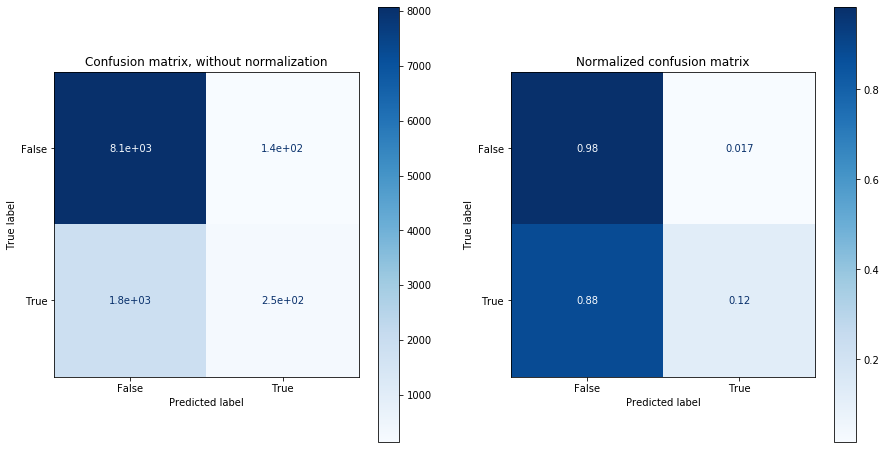

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

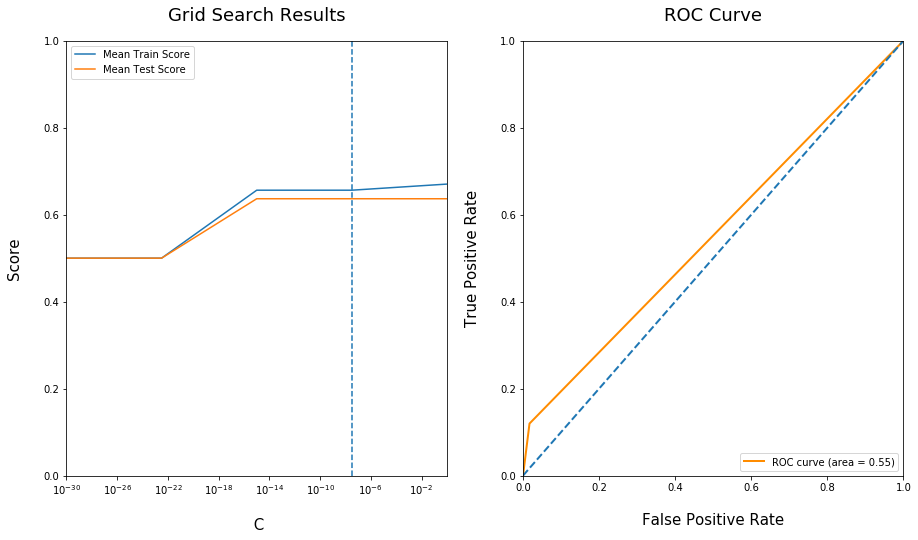

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logisticregression__C', 'mean_train_score', ax=ax1)
results.plot('param_logisticregression__C', 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_["logisticregression__C"], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n C", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
lw = 2
ax2.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_title('ROC Curve', fontsize=18, pad=20)
ax2.set_xlabel('False Positive Rate', fontsize=15, labelpad=20)
ax2.set_ylabel('True Positive Rate', fontsize=15, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.legend(loc="lower right")

plt.show()

We can see that the performance of the model is not good. Precision is okay, but recall for the hotels that have a pool is extremely low. This can also be seen in the confusion matrix. This is very likely to be a problem with how unbalanced the sample is.

We can look at the balance of our sample:

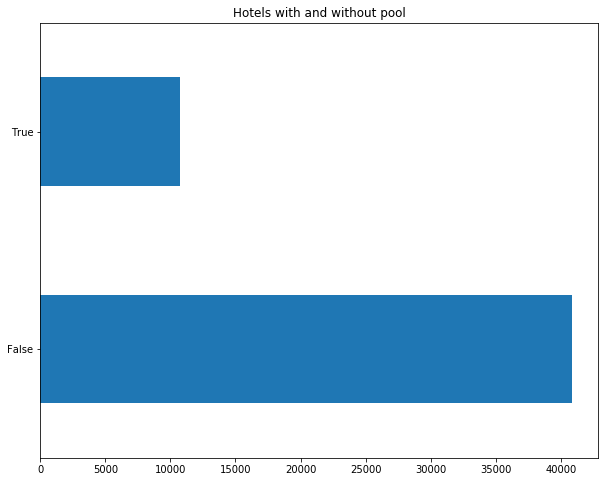

In [90]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
pd.value_counts(df["pool"].values, sort=True).plot.barh()
ax.set_title("Hotels with and without pool")
plt.show()

We can clearly see that there is an extremely low proportion of hotels that have a pool. This makes our sample unbalanced.

From here, we have a few options to explore:

- Class-weights
- Random Undersampling
- Random Oversampling
- Ensemble Resampling
- Edited Nearest Neighbors
- Condensed Nearest Neighbors
- SMOTE

**Class-weights**

We will use sklearn's default `balanced` option which uses the values of `y` to automatically adjust weights inversely proportional to class frequencies in the input data.

In [91]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LogisticRegression(solver="liblinear", random_state=42, multi_class="ovr", max_iter=5000, class_weight="balanced")
)

grid_params = {
    "logisticregression__C": np.logspace(-20, 10, 5),
}

grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="roc_auc")

grid.fit(X_train, y_train)

best_score = grid.best_score_
best_params = grid.best_params_["logisticregression__C"]

print(f"The best ROC AUC score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best macro-average f1 score during CV was: 0.6379039649769896
The best parameter during grid search was: 1e-05


In [92]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.85      0.61      0.71      8217
        True       0.28      0.58      0.38      2098

    accuracy                           0.61     10315
   macro avg       0.57      0.60      0.55     10315
weighted avg       0.74      0.61      0.65     10315



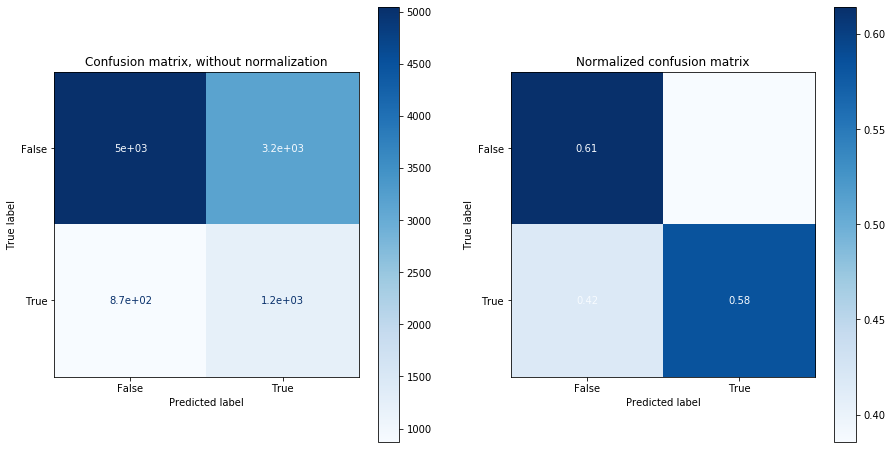

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

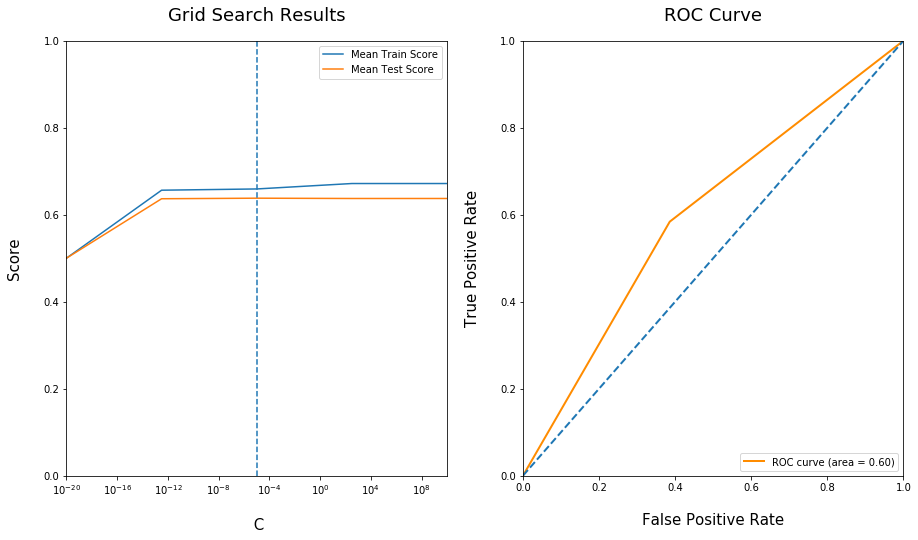

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logisticregression__C', 'mean_train_score', ax=ax1)
results.plot('param_logisticregression__C', 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_["logisticregression__C"], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n C", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
lw = 2
ax2.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_title('ROC Curve', fontsize=18, pad=20)
ax2.set_xlabel('False Positive Rate', fontsize=15, labelpad=20)
ax2.set_ylabel('True Positive Rate', fontsize=15, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.legend(loc="lower right")

plt.show()

We can see that results are improving (AUC from 0.6366 to 0.6379) and the confusion matrix starts to look better. But still the performance is not great.

**Random Undersampling**

We will use `imblearn` to perform some random undersampling and make the sample more balanced.

In [98]:
pipe = make_imb_pipeline(
    RandomUnderSampler(random_state=42),
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LogisticRegression(solver="liblinear", random_state=42, multi_class="ovr", max_iter=5000)
)

grid_params = {
    "logisticregression__C": np.logspace(-20, 50, 5),
}

grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="roc_auc")

grid.fit(X_train, y_train)

best_score = grid.best_score_
best_params = grid.best_params_["logisticregression__C"]

print(f"The best ROC AUC score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best ROC AUC score during CV was: 0.6329059443702467
The best parameter during grid search was: 0.0031622776601683794


In [99]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.85      0.64      0.73      8217
        True       0.28      0.56      0.38      2098

    accuracy                           0.62     10315
   macro avg       0.57      0.60      0.55     10315
weighted avg       0.74      0.62      0.66     10315



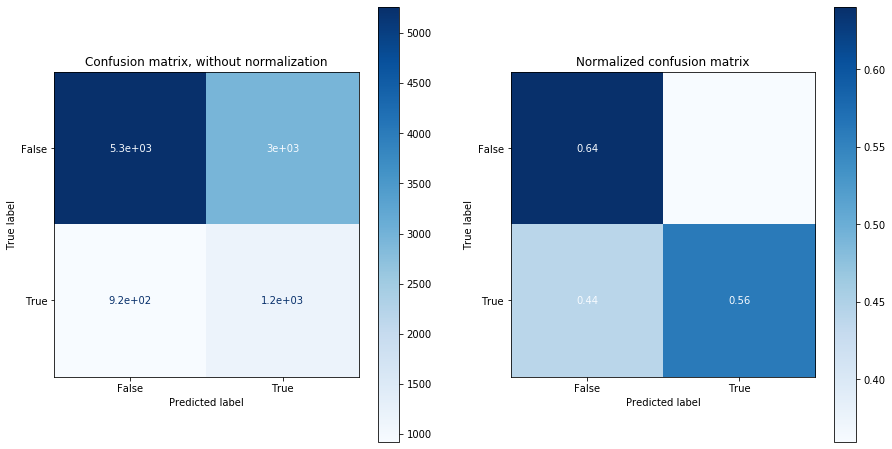

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

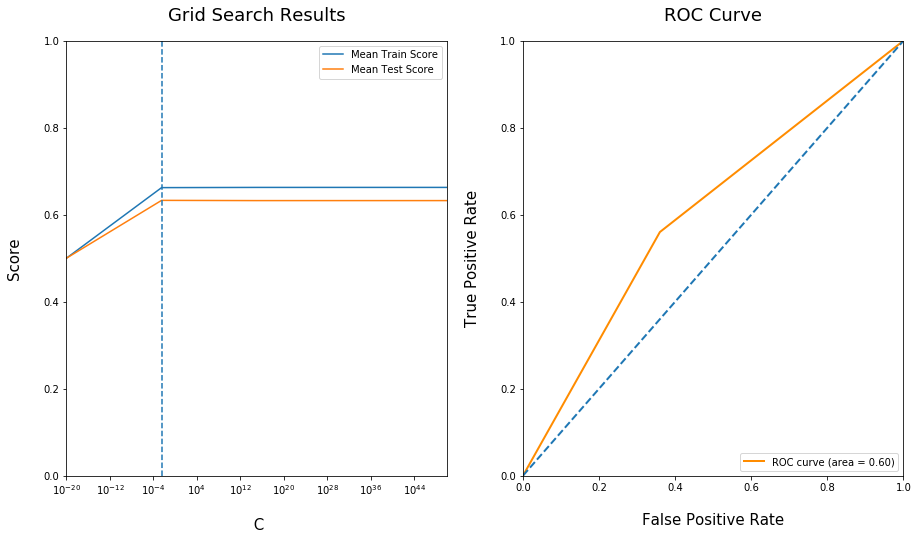

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logisticregression__C', 'mean_train_score', ax=ax1)
results.plot('param_logisticregression__C', 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_["logisticregression__C"], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n C", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
lw = 2
ax2.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_title('ROC Curve', fontsize=18, pad=20)
ax2.set_xlabel('False Positive Rate', fontsize=15, labelpad=20)
ax2.set_ylabel('True Positive Rate', fontsize=15, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.legend(loc="lower right")

plt.show()

The results are worse than the first model. However, a great adavantage of this approach is that it uses a smaller sample which transalates into lower training times.

**Edited Nearest Neighbors**

In [70]:
from imblearn.under_sampling import EditedNearestNeighbours

In [119]:
pipe = make_imb_pipeline(
    EditedNearestNeighbours(n_jobs=-1, kind_sel="mode"),
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LogisticRegression(solver="liblinear", random_state=42, multi_class="ovr", max_iter=5000)
)

grid_params = {
    'editednearestneighbours__n_neighbors': [20, 25, 30, 35], 
#     'editednearestneighbours__kind_sel': ['mode', 'all'],
    "logisticregression__C": np.logspace(-10, 70, 3),
}

grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="roc_auc")

grid.fit(X_train, y_train)

best_score = grid.best_score_
best_params = grid.best_params_["logisticregression__C"]

print(f"The best ROC AUC score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best ROC AUC score during CV was: 0.6366238333721982
The best parameter during grid search was: 1e+30


In [121]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.81      0.99      0.89      8217
        True       0.71      0.09      0.17      2098

    accuracy                           0.81     10315
   macro avg       0.76      0.54      0.53     10315
weighted avg       0.79      0.81      0.74     10315



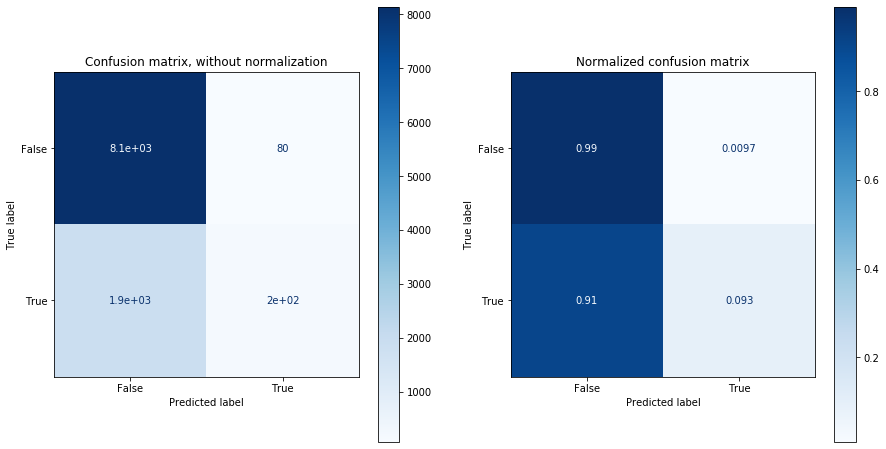

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test, display_labels=["False", "True"],
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

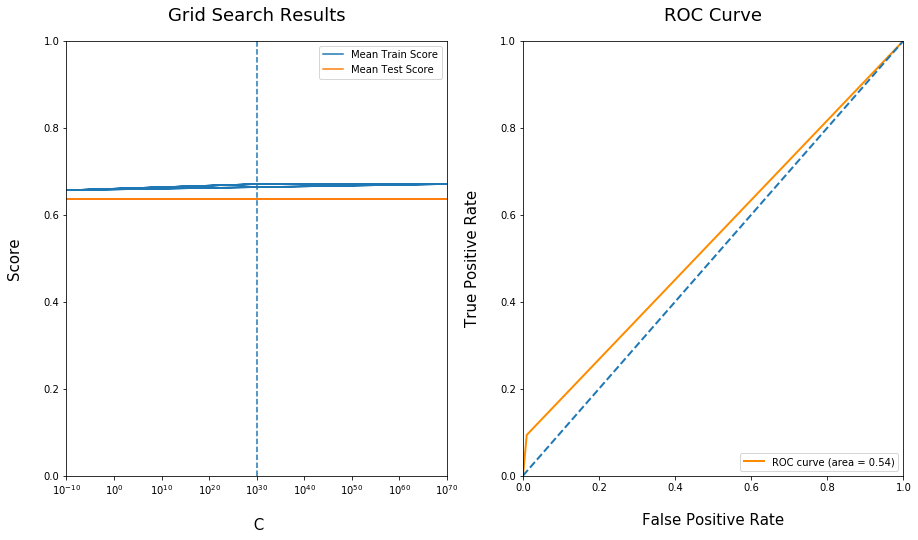

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logisticregression__C', 'mean_train_score', ax=ax1)
results.plot('param_logisticregression__C', 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_["logisticregression__C"], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n C", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
lw = 2
ax2.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_title('ROC Curve', fontsize=18, pad=20)
ax2.set_xlabel('False Positive Rate', fontsize=15, labelpad=20)
ax2.set_ylabel('True Positive Rate', fontsize=15, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.legend(loc="lower right")

plt.show()

**Resampled Ensembles**

In [134]:
def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(
            RandomUnderSampler(random_state=i, replacement=True),
            est
        )
        estimators.append((f"est_{i}", pipe))
    return VotingClassifier(estimators, voting="soft")

In [136]:
resampled_tree_test = make_resampled_ensemble(
    DecisionTreeClassifier(
        max_features='auto',
    ),
    n_estimators=200
)
scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=4, scoring='roc_auc', n_jobs=-1)
print(np.mean(scores))

0.6256838616569982


## Locations

Another feature we can try to predict is the location of the hotel.

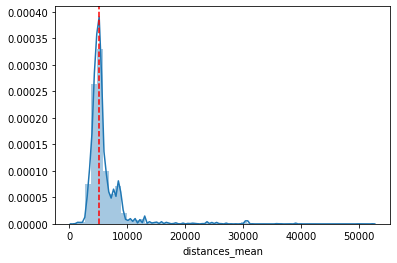

In [86]:
sub = df.dropna(subset=["distances_mean"])
ax = sns.distplot(sub["distances_mean"])
plt.axvline(x=sub["distances_mean"].median(), c="red", ls="--")
plt.show()

To achieve a well-balanced sample and a classification problem, we could try to predict if a hotel is above or below the median of the mean distances to attractions in its city.

However, doing so would be bias in our sample because we have hotels from very different cities (e.g. a mean distance-to-attractions of 2km is not the same in London and in Amsterdam). To control for this, we will compare each hotel to the median of the city they are in.

In [139]:
df["Hotel_Country"] = ""

for index, row in df.iterrows():
    country_name = row["Hotel_Address"].split()[-1]
    df.at[index, "Hotel_Country"] = country_name

In [142]:
locations = df["Hotel_Country"].unique().tolist()

for location in locations:
    median_distance = df[df["Hotel_Country"] == location]["distances_mean"].median()
    df.loc[df["Hotel_Country"] == location, "good_location"] = df[df["Hotel_Country"] == location]["distances_mean"] < median_distance

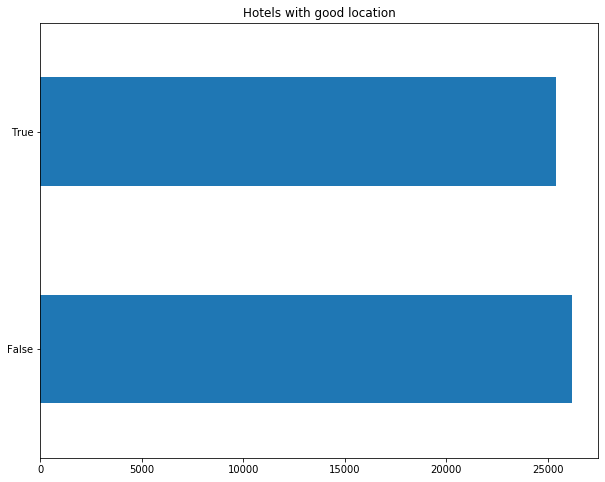

In [144]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
pd.value_counts(df["good_location"].values, sort=True).plot.barh()
ax.set_title("Hotels with good location")
plt.show()

In [145]:
train, test = train_test_split(df, random_state=42, test_size=0.2)

X_train = train[lemma_col + sentiment_col]
y_train = train["good_location"]
X_test = test[lemma_col + sentiment_col]
y_test = test["good_location"]

In [146]:
def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(
            RandomUnderSampler(random_state=i, replacement=True),
            est
        )
        estimators.append((f"est_{i}", pipe))
    return VotingClassifier(estimators, voting="soft")

In [147]:
resampled_tree_test = make_resampled_ensemble(
    DecisionTreeClassifier(
        max_features='auto',
    ),
    n_estimators=200
)
scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=4, scoring='roc_auc', n_jobs=-1)
print(np.mean(scores))

0.5650135314798601
